In [83]:
!pip install nlp

In [84]:
!pip install datasets

In [85]:
!pip install -q -U keras-tuner

In [86]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import nlp
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [87]:
from tensorflow import keras
import keras_tuner as kt

In [88]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [89]:
from datasets import load_dataset

In [90]:
dataset=load_dataset('emotion')

In [91]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [92]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [93]:
def get_info(data):
    texts=[x['text'] for x in data]
    labels=[x['label'] for x in data]
    return texts,labels

In [94]:
texts,labels=get_info(train)

In [140]:
for i in range(5):
  print(texts[i],labels[i])

i didnt feel humiliated 0
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake 0
im grabbing a minute to post i feel greedy wrong 3
i am ever feeling nostalgic about the fireplace i will know that it is still on the property 2
i am feeling grouchy 3


In [96]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


train_texts, train_labels = get_info(train)
lemmatized_train_texts = [lemmatize_text(text) for text in train_texts]
labels = [x['label'] for x in train]

In [97]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [98]:
tokenizer=Tokenizer(num_words=1000,oov_token='<UNK>')
tokenizer.fit_on_texts(lemmatized_train_texts)

In [99]:
tokenizer.texts_to_sequences([texts[0]])

[[2, 139, 3, 678]]

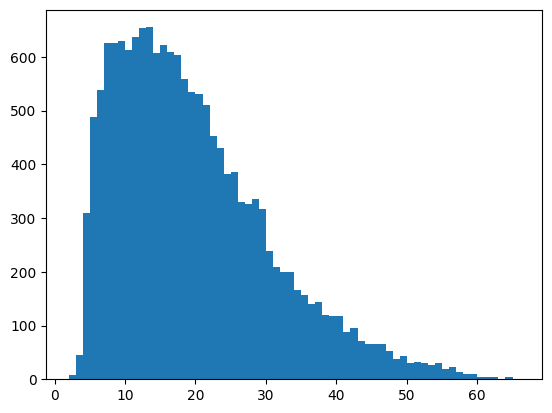

In [100]:
lengths=[len(t.split(' ')) for t in texts]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [101]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlength=50

In [102]:
def get_seq(tokenizer,texts):
    seq=tokenizer.texts_to_sequences(texts)
    pad=pad_sequences(seq,truncating='post',padding='post',maxlen=maxlength)
    return pad

In [103]:
pad_train_seq=get_seq(tokenizer,lemmatized_train_texts)

In [104]:
pad_train_seq[0]

array([  2, 139,   3, 678,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [105]:
div=set(labels)
print(div)

{0, 1, 2, 3, 4, 5}


<function matplotlib.pyplot.show(close=None, block=None)>

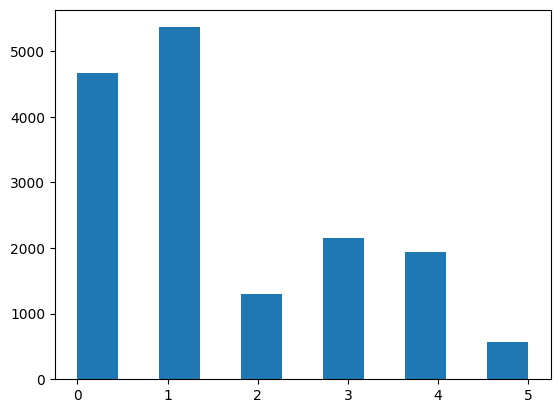

In [106]:
plt.hist(labels,bins=11)
plt.show

In [107]:
div_to_no=dict((c,i) for i,c in enumerate(div))

In [108]:
div_to_id=lambda labels:np.array([div_to_no.get(x) for x in labels])
train_labels=div_to_id(labels)

In [109]:
val_texts, val_labels = get_info(val)
lemmatized_val_texts = [lemmatize_text(text) for text in val_texts]
val_seq = get_seq(tokenizer, lemmatized_val_texts)
val_labels = div_to_id(val_labels)

In [110]:
test_texts, test_labels = get_info(test)
lemmatized_test_texts = [lemmatize_text(text) for text in test_texts]
test_seq = get_seq(tokenizer, lemmatized_test_texts)
test_labels = div_to_id(test_labels)

Bidirectional LSTM with basic embedding

In [111]:
'''model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(1000,16,input_length=maxlength),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)'''

"model=tf.keras.models.Sequential([\n    tf.keras.layers.Embedding(1000,16,input_length=maxlength),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),\n    tf.keras.layers.Dense(6,activation='softmax')\n])\nmodel.compile(\n    loss='sparse_categorical_crossentropy',\n    optimizer='adam',\n    metrics=['accuracy']\n)"

In [112]:
#model.summary()

In [113]:
val_texts,val_labels=get_info(val)
val_seq=get_seq(tokenizer,val_texts)
val_labels=div_to_id(val_labels)

In [114]:
#tuner = kt.RandomSearch(model,objective='val_accuracy',max_trials=5)

In [115]:
#tuner.search(pad_train_seq, train_labels, validation_data=(val_seq, val_labels))
#best_model = tuner.get_best_models()[0]

In [116]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(1000, hp.Int('embedding_units', min_value=8, max_value=32, step=8), input_length=maxlength))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('lstm_units', min_value=16, max_value=64, step=16), return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('lstm_units', min_value=16, max_value=64, step=16))))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_directory',
    project_name='emotion_classification'
)




tuner.search(pad_train_seq, train_labels, epochs=6, validation_data=(val_seq, val_labels))


best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 04m 06s]
val_accuracy: 0.8604999780654907

Best val_accuracy So Far: 0.8725000023841858
Total elapsed time: 00h 37m 24s


In [123]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 96)           24960     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 96)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 582       
                                                                 
Total params: 97,222
Trainable params: 97,222
Non-trainable params: 0
_________________________________________________________________


In [117]:
#analyser = model.fit(pad_train_seq, train_labels, validation_data=(val_seq, val_labels), epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)])
#analyser=model.fit(
 #              pad_train_seq,train_labels,validation_data=(val_seq,val_labels),
  #             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)])

In [124]:
test_texts,test_labels=get_info(test)
test_seq=get_seq(tokenizer,test_texts)
test_labels=div_to_id(test_labels)

In [125]:
test[0]

{'text': 'im feeling rather rotten so im not very ambitious right now',
 'label': 0}

In [126]:
print('Sentence:',test_texts[0])
print('Emotion:',test_labels[0])
prediction=best_model.predict(np.expand_dims(test_seq[0],axis=0))[0]
print('Predicted Emotion:',np.argmax(prediction).astype('uint8'))

Sentence: im feeling rather rotten so im not very ambitious right now
Emotion: 0
1/1 [==============================] - 0s 32ms/step
Predicted Emotion: 0


In [127]:
test_loss,test_accuracy = best_model.evaluate(test_seq,test_labels)
print(test_loss,test_accuracy)

63/63 [==============================] - 3s 46ms/step - loss: 0.3238 - accuracy: 0.8765
0.3238060772418976 0.8765000104904175


In [128]:
from sklearn.metrics import f1_score

In [129]:
prediction = best_model.predict(test_seq)
predicted_labels = np.argmax(prediction,axis=1)
f1 = f1_score(test_labels,predicted_labels,average='weighted')
print(f1)

63/63 [==============================] - 3s 42ms/step
0.8757345243949405


GRU+ with normal embedding

In [133]:
'''def build_model2(hp):
    model = tf.keras.models.Sequential()


    model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), input_length=maxlength))


    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hp.Int('gru_units', min_value=32, max_value=128, step=32), return_sequences=True)))


    model.add(tf.keras.layers.Conv1D(filters=hp.Int('conv_filters', min_value=64, max_value=256, step=64), kernel_size=hp.Int('conv_kernel', min_value=3, max_value=7, step=2), activation='relu'))


    model.add(tf.keras.layers.GlobalMaxPooling1D())


    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))


    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_directory',  # Directory where to store tuning results
    project_name='emotion_classification'
)




tuner2.search(pad_train_seq, train_labels, epochs=6, validation_data=(val_seq, val_labels))


best_model2 = tuner2.get_best_models(num_models=1)[0]'''

"def build_model2(hp):\n    model = tf.keras.models.Sequential()\n\n    # Embedding layer\n    model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), input_length=maxlength))\n\n    # Bidirectional GRU layer\n    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hp.Int('gru_units', min_value=32, max_value=128, step=32), return_sequences=True)))\n\n    # Convolutional layer\n    model.add(tf.keras.layers.Conv1D(filters=hp.Int('conv_filters', min_value=64, max_value=256, step=64), kernel_size=hp.Int('conv_kernel', min_value=3, max_value=7, step=2), activation='relu'))\n\n    # Global Max Pooling layer\n    model.add(tf.keras.layers.GlobalMaxPooling1D())\n\n    # Dense layers\n    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))\n    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2

In [134]:
best_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=maxlength),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

best_model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [135]:
best_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1360800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          63744     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [136]:
analyser = best_model2.fit(pad_train_seq, train_labels, validation_data=(val_seq, val_labels), epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)])
#analyser=model.fit(
 #              pad_train_seq,train_labels,validation_data=(val_seq,val_labels),
  #             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)])

Epoch 1/30
500/500 [==============================] - 59s 110ms/step - loss: 0.9711 - accuracy: 0.6295 - val_loss: 0.4060 - val_accuracy: 0.8615
Epoch 2/30
500/500 [==============================] - 56s 111ms/step - loss: 0.3629 - accuracy: 0.8683 - val_loss: 0.3627 - val_accuracy: 0.8565
Epoch 3/30
500/500 [==============================] - 53s 106ms/step - loss: 0.3046 - accuracy: 0.8823 - val_loss: 0.3291 - val_accuracy: 0.8700
Epoch 4/30
500/500 [==============================] - 56s 113ms/step - loss: 0.2719 - accuracy: 0.8884 - val_loss: 0.3310 - val_accuracy: 0.8665
Epoch 5/30
500/500 [==============================] - 53s 105ms/step - loss: 0.2472 - accuracy: 0.8923 - val_loss: 0.3468 - val_accuracy: 0.8650


In [137]:
print('Sentence:',test_texts[0])
print('Emotion:',test_labels[0])
prediction=best_model2.predict(np.expand_dims(test_seq[0],axis=0))[0]
print('Predicted Emotion:',np.argmax(prediction).astype('uint8'))

Sentence: im feeling rather rotten so im not very ambitious right now
Emotion: 0
1/1 [==============================] - 1s 761ms/step
Predicted Emotion: 0


In [138]:
test_loss2,test_accuracy2 = best_model2.evaluate(test_seq,test_labels)
print(test_loss2,test_accuracy2)

63/63 [==============================] - 3s 40ms/step - loss: 0.3097 - accuracy: 0.8665
0.30971765518188477 0.8665000200271606


In [139]:
prediction2 = best_model2.predict(test_seq)
predicted_labels2 = np.argmax(prediction2,axis=1)
f1_2 = f1_score(test_labels,predicted_labels2,average='weighted')
print(f1_2)

63/63 [==============================] - 1s 21ms/step
0.865226331746653
